In [1]:
import pywt
import matplotlib.pyplot as plt
from sktime.libs.vmdpy import VMD

import torch
from torch import nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns


In [9]:
data = pd.read_csv("data/3号机组抽水态健康样本.csv",encoding="GBK")

In [10]:
deter_data = pd.read_csv("data/3号机组抽水态劣化样本.csv",encoding="GBK")
c = deter_data.水头
deter_data.水头 = deter_data.导叶开度
deter_data.导叶开度 = c

In [ ]:
for i in range(data.iloc[:,13:].columns.__len__()):
    sns.set() 
    plt.figure(figsize=(12, 5))  
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.subplot(121)
    sns.distplot(data.iloc[:,13+i])
    plt.subplot(122)
    sns.distplot(deter_data.iloc[:,7+i])
    plt.show()

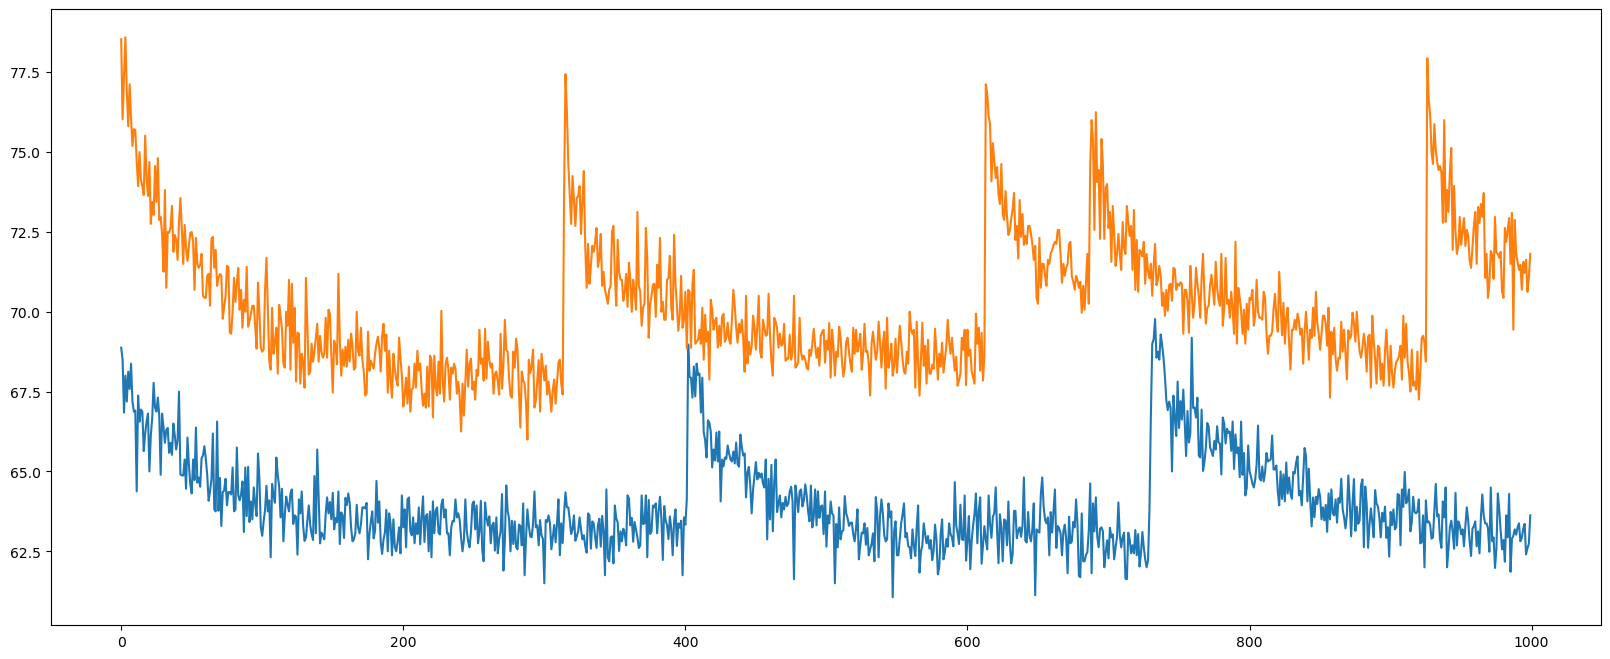

In [73]:
plt.figure(figsize=(20,8))
plt.plot(data.iloc[:1000,1])
plt.plot(deter_data.iloc[:1000,1])

In [4]:
alpha = 2000  # 中等带宽约束
tau = 0.0  # 容忍噪声（不强制保真度）
K = 4  # 预期3个模式
DC = 0  # 不施加直流部分的约束
init = 1  # 统一初始化频域系数
tol = 1e-7
f=data.上导摆度X

u, u_hat, omega = VMD(f, alpha, tau, K, DC, init, tol)

In [22]:
from scipy.signal import butter, filtfilt
def low_pass_filter(signal, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

cutoff = 1.0  # 截止频率
fs = 50.0     # 采样频率
trend_lpf = low_pass_filter(f, cutoff, fs)


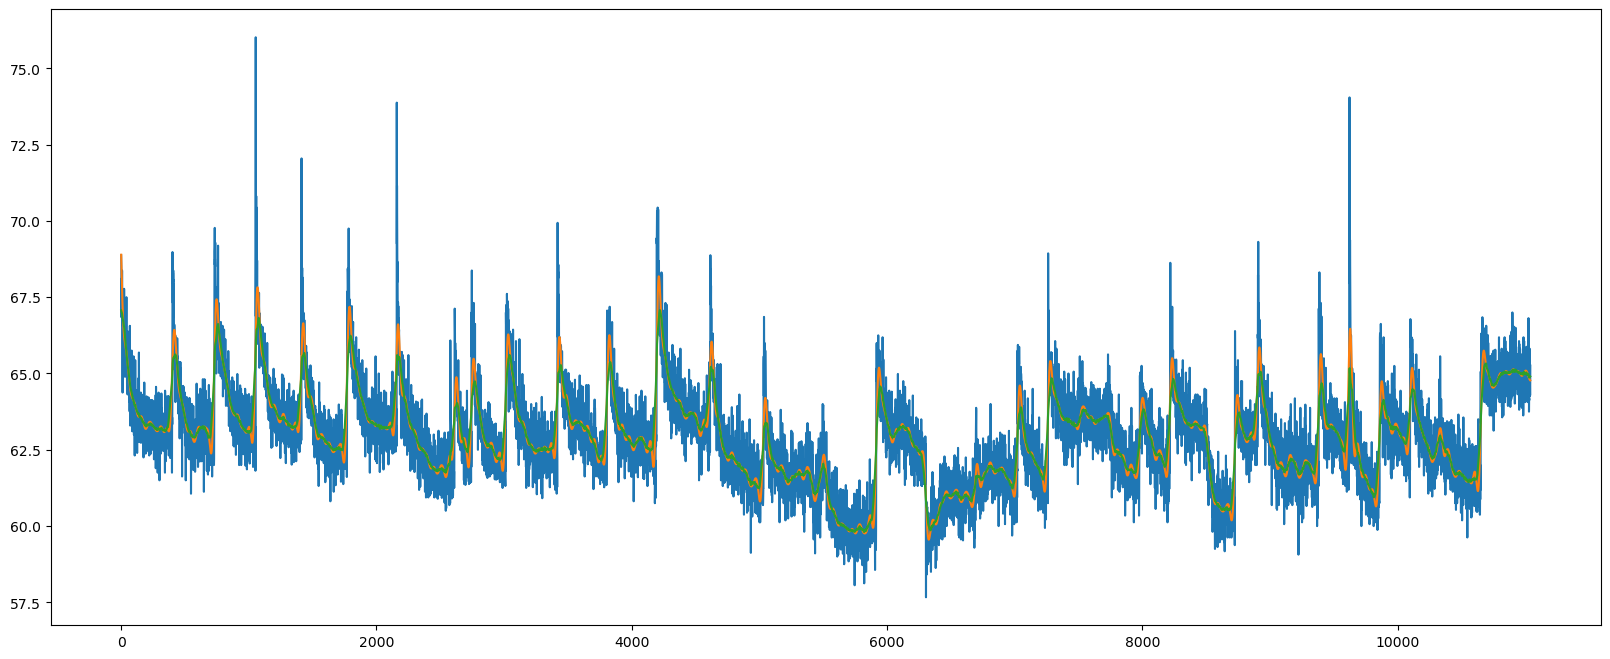

In [27]:
plt.figure(figsize=(20, 8))
plt.plot(data.上导摆度X)
plt.plot(trend_lpf)
plt.plot(u[0])

In [11]:
X,target=data.iloc[:,13:], data.上导摆度X
# target,_,__ = VMD(target, alpha, tau, K, DC, init, tol)
sc = MinMaxScaler()
sc2 = MinMaxScaler()
y=sc.fit_transform(np.array(target).reshape(-1, 1))
X=sc2.fit_transform(X)


In [16]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size):
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.Linear(128, 64),
            nn.Dropout(.5),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def fit(self, X, y, epochs=500):
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            y_pred = self.model(X)
            loss = self.loss_fn(y_pred, y)
            loss.backward()
            self.optimizer.step()
            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss {loss.item()}')

    def predict(self, X):
        return self.model(X)

In [17]:
MLP(6,100,1).fit(torch.Tensor(X),torch.Tensor(y))

Epoch 0, Loss 0.19087430834770203
Epoch 10, Loss 0.0226347204297781
Epoch 20, Loss 0.021477829664945602
Epoch 30, Loss 0.020816145464777946
Epoch 40, Loss 0.016412900760769844
Epoch 50, Loss 0.013974778354167938
Epoch 60, Loss 0.013008888810873032
Epoch 70, Loss 0.01246244553476572
Epoch 80, Loss 0.011966222897171974
Epoch 90, Loss 0.011677724309265614
Epoch 100, Loss 0.011298127472400665
Epoch 110, Loss 0.010923103429377079
Epoch 120, Loss 0.010551112703979015
Epoch 130, Loss 0.010157421231269836
Epoch 140, Loss 0.009798961691558361
Epoch 150, Loss 0.009570947848260403
Epoch 160, Loss 0.00939096137881279
Epoch 170, Loss 0.009194327518343925
Epoch 180, Loss 0.008927855640649796
Epoch 190, Loss 0.00878333393484354
Epoch 200, Loss 0.008649560622870922
Epoch 210, Loss 0.008514957502484322
Epoch 220, Loss 0.008509562350809574
Epoch 230, Loss 0.008291628211736679
Epoch 240, Loss 0.008214415982365608
Epoch 250, Loss 0.008144035004079342
Epoch 260, Loss 0.008179550990462303
Epoch 270, Loss 0.

In [23]:
deter_data.iloc[:,7:].var()

有功功率      14.970170
无功功率     486.752477
励磁电流    7104.506106
励磁电压    1095.811022
水头         4.293617
导叶开度      55.219920
dtype: float64

In [18]:
predict = sc.inverse_transform(MLP(6,100,1).predict(torch.Tensor(sc2.fit_transform(deter_data.iloc[:,7:]))).detach().numpy()).flatten()

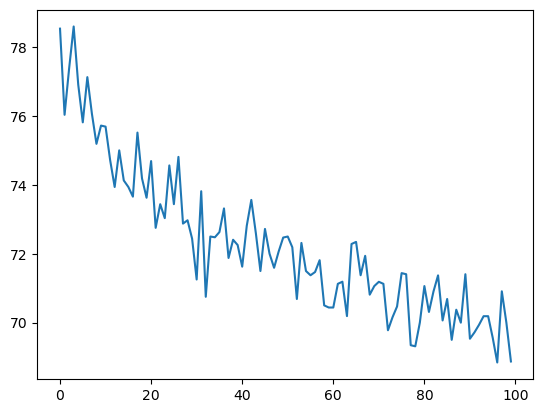

In [38]:
plt.plot(deter_data.iloc[:100,1])

In [18]:
c,_,__ = VMD(deter_data.iloc[:,1], alpha, tau, K, DC, init, tol)

In [20]:
c[0][:100]

array([75.54721266, 75.52743752, 75.51642397, 75.49617718, 75.44919294,
       75.39621275, 75.34760458, 75.28378711, 75.21312531, 75.14570058,
       75.07290372, 74.98862378, 74.9033599 , 74.82598442, 74.74105664,
       74.65750797, 74.57944766, 74.5011559 , 74.40394856, 74.30123995,
       74.19800359, 74.08920396, 73.99141372, 73.89957948, 73.81578632,
       73.71688133, 73.61547565, 73.499665  , 73.38075315, 73.26576688,
       73.15912889, 73.07060581, 72.98152349, 72.91102272, 72.84382357,
       72.77755495, 72.70569147, 72.63017083, 72.56224977, 72.49320548,
       72.43039698, 72.37906049, 72.32579007, 72.25960863, 72.18877532,
       72.12778385, 72.06742198, 72.01228521, 71.9665784 , 71.92241767,
       71.87020883, 71.81188316, 71.75416108, 71.70551336, 71.64966346,
       71.59266623, 71.53695756, 71.48269405, 71.41996262, 71.36172371,
       71.31777004, 71.28524549, 71.25734484, 71.23185894, 71.21112128,
       71.17796045, 71.13347011, 71.08529173, 71.02793639, 70.96

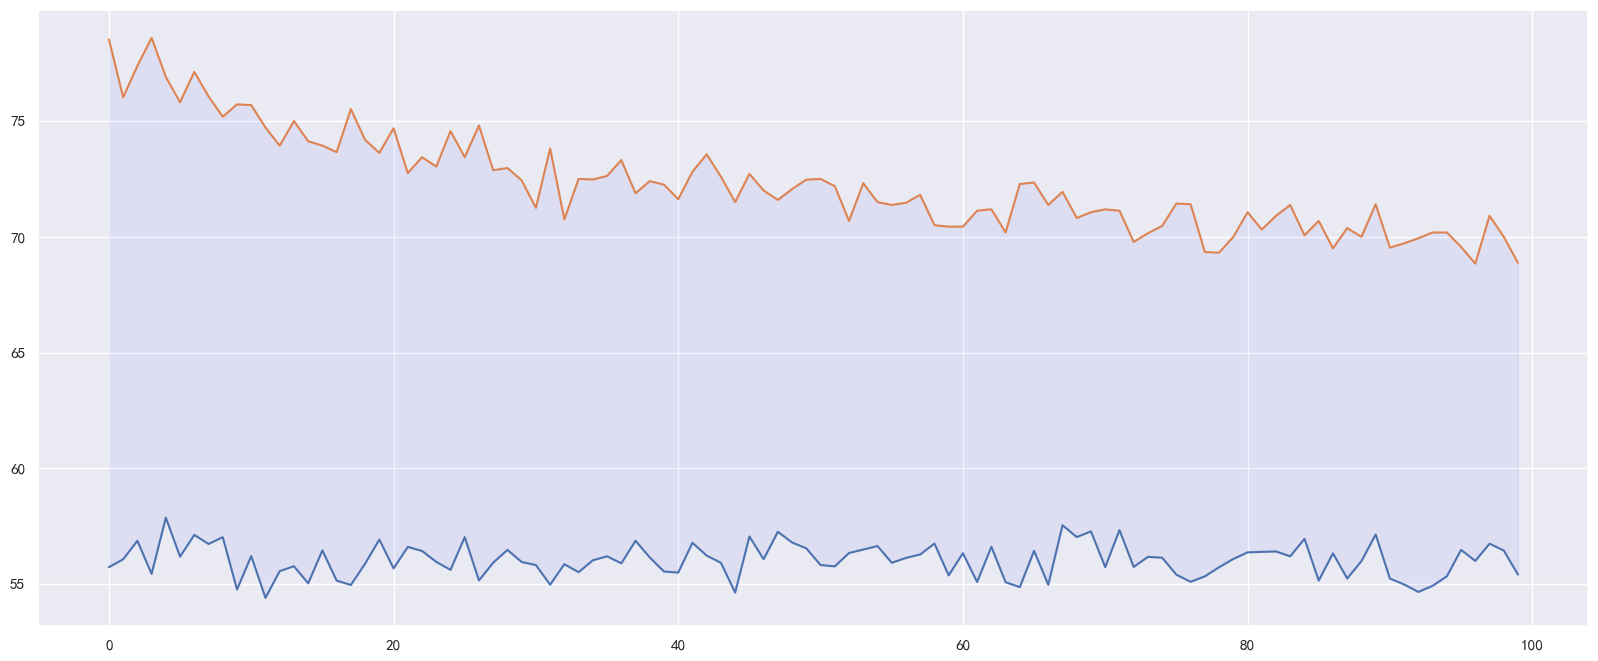

In [22]:
plt.figure(figsize=(20, 8))
plt.plot(predict[:100])
plt.plot(deter_data.iloc[:100,1])
plt.fill_between(y1=predict[:100], y2=deter_data.iloc[:100,1], color='blue', alpha=0.05,x=range(100))

In [24]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [25]:
X,target=data.iloc[:,13:], data.上导摆度X

In [34]:
y=target
sc = MinMaxScaler()
sc2 = MinMaxScaler()
y=sc.fit_transform(np.array(y).reshape(-1, 1))
X=sc2.fit_transform(X)
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=32)
lgbmr_model = LGBMRegressor(
        colsample_bytree=0.7,
        learning_rate=0.055,
        min_child_samples=10,
        num_leaves=15,
        objective='regression',
        n_estimators=1000,
        n_jobs=5,
        random_state=337)
lgbmr_model.fit(X, y)
lgbmr_pred = lgbmr_model.predict(x_test)
print(mse(sc.inverse_transform(y_test),sc.inverse_transform(lgbmr_model.predict(x_test).reshape(-1,1))))

d:\anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 11040, number of used features: 6
[LightGBM] [Info] Start training from score 0.288935
0.9273694157611028


In [35]:
predict = sc.inverse_transform(lgbmr_model.predict(sc2.fit_transform(deter_data.iloc[:100,7:])).reshape(-1,1)).flatten()

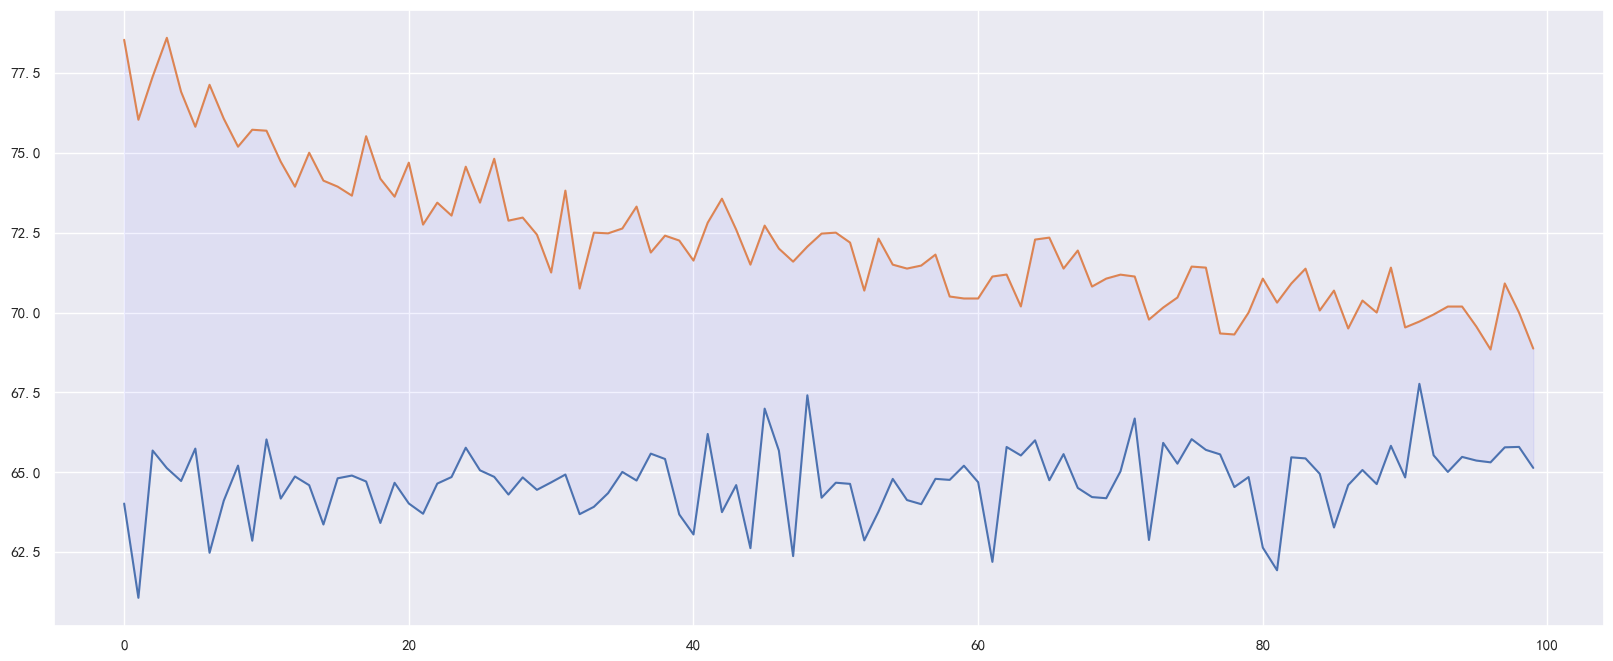

In [38]:
plt.figure(figsize=(20, 8))
plt.plot(predict)
# plt.plot(target.values[:100])
plt.plot(deter_data.iloc[:100,1])
plt.fill_between(y1=predict, y2=deter_data.iloc[:100,1], color='blue', alpha=0.05,x=range(100))

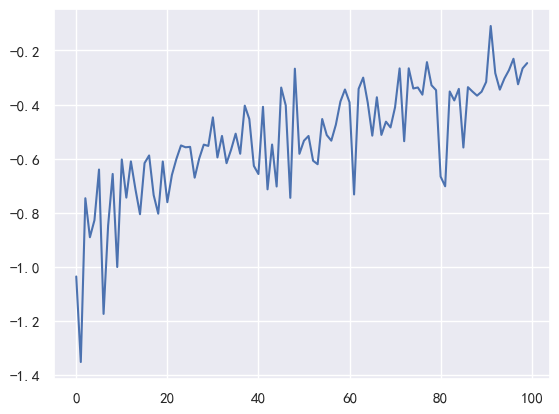

In [37]:
D_t = (np.array(deter_data.iloc[:100,1])-predict[:100])/(50-predict[:100])
plt.plot(D_t)

In [29]:
import pandas as pd
def compress_series(inputser: pd.Series, compfactor=2):
  """
  Split into segments and pick 3 points from each segment, the minimum,
  median, and maximum. Segment length = int(compfactor x 3). So, to achieve a
  compression factor of 2, a segment length of 6 is needed.
  Parameters
  ----------
  inputser : pd.Series
      Input data to be compressed.
  compfactor : float
      Compression factor. The default is 2.
  Returns
  -------
  pd.Series
      Compressed output series.
  """
  # If comp factor is too low, return original data
  if (compfactor < 1.4):
      return inputser
  win_size = int(3 * compfactor)  # window size
  # Create a column ofsegment numbers
  ser = inputser.rename('value')
  ser = ser.round(3)
  wdf = ser.to_frame()
  del ser
  start_idxs = wdf.index[range(0, len(wdf), win_size)]
  wdf['win_start'] = 0
  wdf.loc[start_idxs, 'win_start'] = 1
  wdf['win_num'] = wdf['win_start'].cumsum()
  wdf.drop(columns='win_start', inplace=True)
  del win_size, start_idxs
  # For each window, get the indices of min, median, and max
  def get_midimax_idxs(gdf):
      if len(gdf) == 1:
          return [gdf.index[0]]
      elif gdf['value'].iloc[0] == gdf['value'].iloc[-1]:
          return [gdf.index[0]]
      elif len(gdf) == 2:
          return [gdf.index[0], gdf.index[1]]
      else:
          return [gdf.index[0], gdf.index[len(gdf) // 2], gdf.index[-1]]
  wdf = wdf.dropna()
  wdf_sorted = wdf.sort_values(['win_num', 'value'])
  midimax_idxs = wdf_sorted.groupby('win_num').apply(get_midimax_idxs)
  # Convert into a list
  midimax_idxs = [idx for sublist in midimax_idxs for idx in sublist]
  midimax_idxs.sort()
  return inputser.loc[midimax_idxs]

In [ ]:
class Serise_EDA:
    def __init__(self):
        pass

In [ ]:
class Serise_process:
    def __init__(self):
        pass
    
    def seirse_condense(self):
        pass

    def load_serise(self):
        pass

    def vmd_denoise(self):
        pass 